C:\Users\flare\AppData\Local\Temp\ipykernel_12008\3555034133.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mnist_cnn.pth"))  # 事前学習済

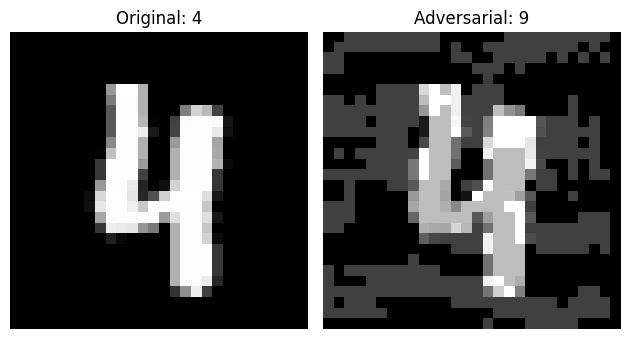

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# モデル定義（簡単なCNN）
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# データセット読み込み
transform = transforms.ToTensor()
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
model.load_state_dict(torch.load("mnist_cnn.pth"))  # 事前学習済みモデルが必要
model.eval()

# FGSM関数
def fgsm_attack(image, epsilon, data_grad):
    return torch.clamp(image + epsilon * data_grad.sign(), 0, 1)

# 1枚選んで攻撃
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
images.requires_grad = True

output = model(images)
init_pred = output.max(1, keepdim=True)[1]

loss = F.nll_loss(F.log_softmax(output, dim=1), labels)
model.zero_grad()
loss.backward()
data_grad = images.grad.data

epsilon = 0.25
perturbed_data = fgsm_attack(images, epsilon, data_grad)

# 攻撃後予測
output_adv = model(perturbed_data)
final_pred = output_adv.max(1, keepdim=True)[1]

# 表示
plt.subplot(1, 2, 1)
plt.title(f"Original: {init_pred.item()}")
plt.imshow(images.squeeze().cpu().detach(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Adversarial: {final_pred.item()}")
plt.imshow(perturbed_data.squeeze().cpu().detach(), cmap="gray")
plt.axis('off')
plt.tight_layout()
plt.show()
